## Project: Predicting habitable/non-habitable of a planet

Attempt to predict the habitable/non-habitable of a planet using kNN model. Features are stellar mass, orbital period of the planet and the distance of the planet to its star.

Dataset:
* `data/HPLearningSet.csv` - a curated dataset
>Data extracted from the real dataset on URL `` - see **[Acquaviva2021]**

**TODO: check the used dataframes and REDO the exercises.**

#### Source
**[Acquaviva2021]**  Acquaviva, Vivianne, *Machine learning for Physics and Astronomy*,  **chapter 2**

**Dependencies**  `conda env project_ai`

##### History
* 2025-0606 PP redo exercise, pay more attention to the different dataframes.
* 2025-0501 PP setup according to source

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# versions of Python and libraries
import sys
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Python         : {sys.version}")
print()
print(f"Pandas    : {pd.__version__}")
print(f"Numpy     : {np.__version__}")
print()
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn   : {sns.__version__}")

Python Platform: macOS-15.5-arm64-arm-64bit
Python         : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]

Pandas    : 2.2.3
Numpy     : 1.26.4

Matplotlib: 3.9.2
Seaborn   : 0.13.2


In [3]:
# Set the style for all plots
sns.set_style("whitegrid")
fontsize = 15 #20
font = {'size'   : fontsize}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
matplotlib.rcParams['figure.dpi'] = 300

---
## Part 1 - use the original data

### Step 0: Load the dataset

Read the sample dataset `HPLearningSet.csv`:
- 'Unnamed:0': an index number
- 'P_NAME': name of the plnet, a unique identifier for each planet
- 'S_MASS': mass of the parent star, expressed in units of the mass of the Sun
- 'P_PERIOD': the orbital period of the planet, in days
- 'P_DISTANCE': the distance between the planet and its parent star, in astronomical units
- 'P_HABITABLE': whether the planet might be habital or not
- 

In [4]:
learning_set = pd.read_csv("data/HPLearningSet.csv")
learning_set = learning_set.drop(learning_set.columns[0], axis=1) #We want to drop the first column of the file
learning_set

,P_NAME,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,Kepler-736 b,0.86,3.601472,0.043718,0
1,Kepler-636 b,0.85,16.080661,0.118082,0
2,Kepler-887 c,1.19,7.638460,0.080420,0
3,Kepler-442 b,0.61,112.305300,0.409327,1
4,Kepler-772 b,0.98,12.992073,0.107408,0
5,Teegarden's Star b,0.09,4.910000,0.025200,1
6,K2-116 b,0.69,4.655411,0.048086,0
7,GJ 1061 c,0.12,6.689000,0.035000,1
8,HD 68402 b,1.12,1103.000000,2.180981,0
9,Kepler-1544 b,0.81,168.811170,0.557107,1


In [5]:
# split the learning_set in a training set (df_train) and a test set (df_test)
df_train = learning_set.iloc[:13,:]
df_test = learning_set.iloc[13:,:]

print(f"df_train shape: {df_train.shape}")
print(f"df_test shape : {df_test.shape}")

df_train shape: (13, 5)
df_test shape : (5, 5)


In [6]:
# split the sets in features and labels
# features: stellar mass, period, and distance
# label/target: habitable/non-habitable of the planet
# Note: P_NAME is not numeric, so we drop it too.

Xtrain = df_train.drop(['P_NAME','P_HABITABLE'],axis=1)
ytrain = df_train.P_HABITABLE

Xtest  = df_test.drop(['P_NAME','P_HABITABLE'],axis=1)
ytest  = df_test.P_HABITABLE

df_train.head()

,P_NAME,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,Kepler-736 b,0.86,3.601472,0.043718,0
1,Kepler-636 b,0.85,16.080661,0.118082,0
2,Kepler-887 c,1.19,7.638460,0.080420,0
3,Kepler-442 b,0.61,112.305300,0.409327,1
4,Kepler-772 b,0.98,12.992073,0.107408,0


### Step 1: Exploratory Data Analysis

#### 1.1 Basic Dataset Information

In [7]:
# See first few rows (default is 5)
Xtrain.head()

,S_MASS,P_PERIOD,P_DISTANCE
0,0.86,3.601472,0.043718
1,0.85,16.080661,0.118082
2,1.19,7.638460,0.080420
3,0.61,112.305300,0.409327
4,0.98,12.992073,0.107408


In [8]:
Xtrain.shape

(13, 3)

In [9]:
# Print all column names
print("\nColumn Names:")
print(Xtrain.columns.tolist())


Column Names:
['S_MASS', 'P_PERIOD', 'P_DISTANCE']


#### 1.2 Data Summary Statistics

In [10]:
#print(Xtrain[['S_MASS', 'P_PERIOD', 'P_DISTANCE']].describe())
Xtrain.describe()

,S_MASS,P_PERIOD,P_DISTANCE
count,13.000000,13.000000,13.000000
mean,0.656154,118.134842,0.311323
std,0.363560,300.168519,0.584465
min,0.090000,3.601472,0.025200
25%,0.500000,4.910000,0.043718
50%,0.690000,12.992073,0.107408
75%,0.860000,56.056054,0.231926
max,1.190000,1103.000000,2.180981


#### 1.3 Class Distribution

In [11]:
#class_dist = df_train['P_HABITABLE'].value_counts()
#print(class_dist)
df_train['P_HABITABLE'].value_counts()

P_HABITABLE
0    7
1    6
Name: count, dtype: int64

#### 1.4 Data Visualization

Make a plot of training-dataset dataframe, or, test_dataset dataframe, using two features and colored according to habitable/non-habitable of the planet.

Features: S_MASS, P_PERIOD
- training set: df_train
- test set: df_test

Note: dataframe must contain the target P_HABITABLE

In [14]:
def plot_planet_data(df, title="", save_plot=False):
    """
    plot_planet_data() - make a nice plot of dataset, 
    using target for marker and colors
    
    Arguments
        - df, DataFrame: a dataframe with the target ('P_HABITABLE') included.
        - save_plot, bool: True - save plot in file, default=False
    """
    for outcome, color, marker, size in [
        (1, '#20B2AA', 'o', 100),  # Blue-ish bubbles for habitable planet
        (0, '#FF00FF', 'x', 100)  # Magenta crosses for not-habitable planet
    ]:
        mask = df['P_HABITABLE'] == outcome
        # use two features: S_MASS and P_PERIOD
        plt.scatter(df[mask]['S_MASS'], 
                df[mask]['P_PERIOD'],
                #df[mask]['P_DISTANCE'],
                c=color,
                marker=marker,
                s=size,
                label="Habital" if outcome == 1 else "Non-Habital",
                alpha=0.7,
                linewidth=2)  # Make the markers thicker
        #a = plt.scatter(TrainSet['S_MASS'], TrainSet['P_PERIOD'], marker = '*',facecolor = 'none',\
        #    c = TrainSet['P_HABITABLE'], s = 100, label = 'Train', cmap=cmap) 
    
    plt.title(title, pad=20, size=15)
    plt.xlabel('Mass of Parent Star (Solar Mass Units)')  #, size=10)
    plt.ylabel('Period of Orbit (days)') #, size=10)
    plt.legend(title='habitable/non-habitable of Planet', title_fontsize=10, fontsize=10, loc="upper left")

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust axis limits to add some padding
    plt.xlim(-130,70)
    plt.ylim(0,140)

    if save_plot:
        plt.savefig(f"images/HabPlanets_{title.replace(' ' , '')}_Period.png", dpi = 250)

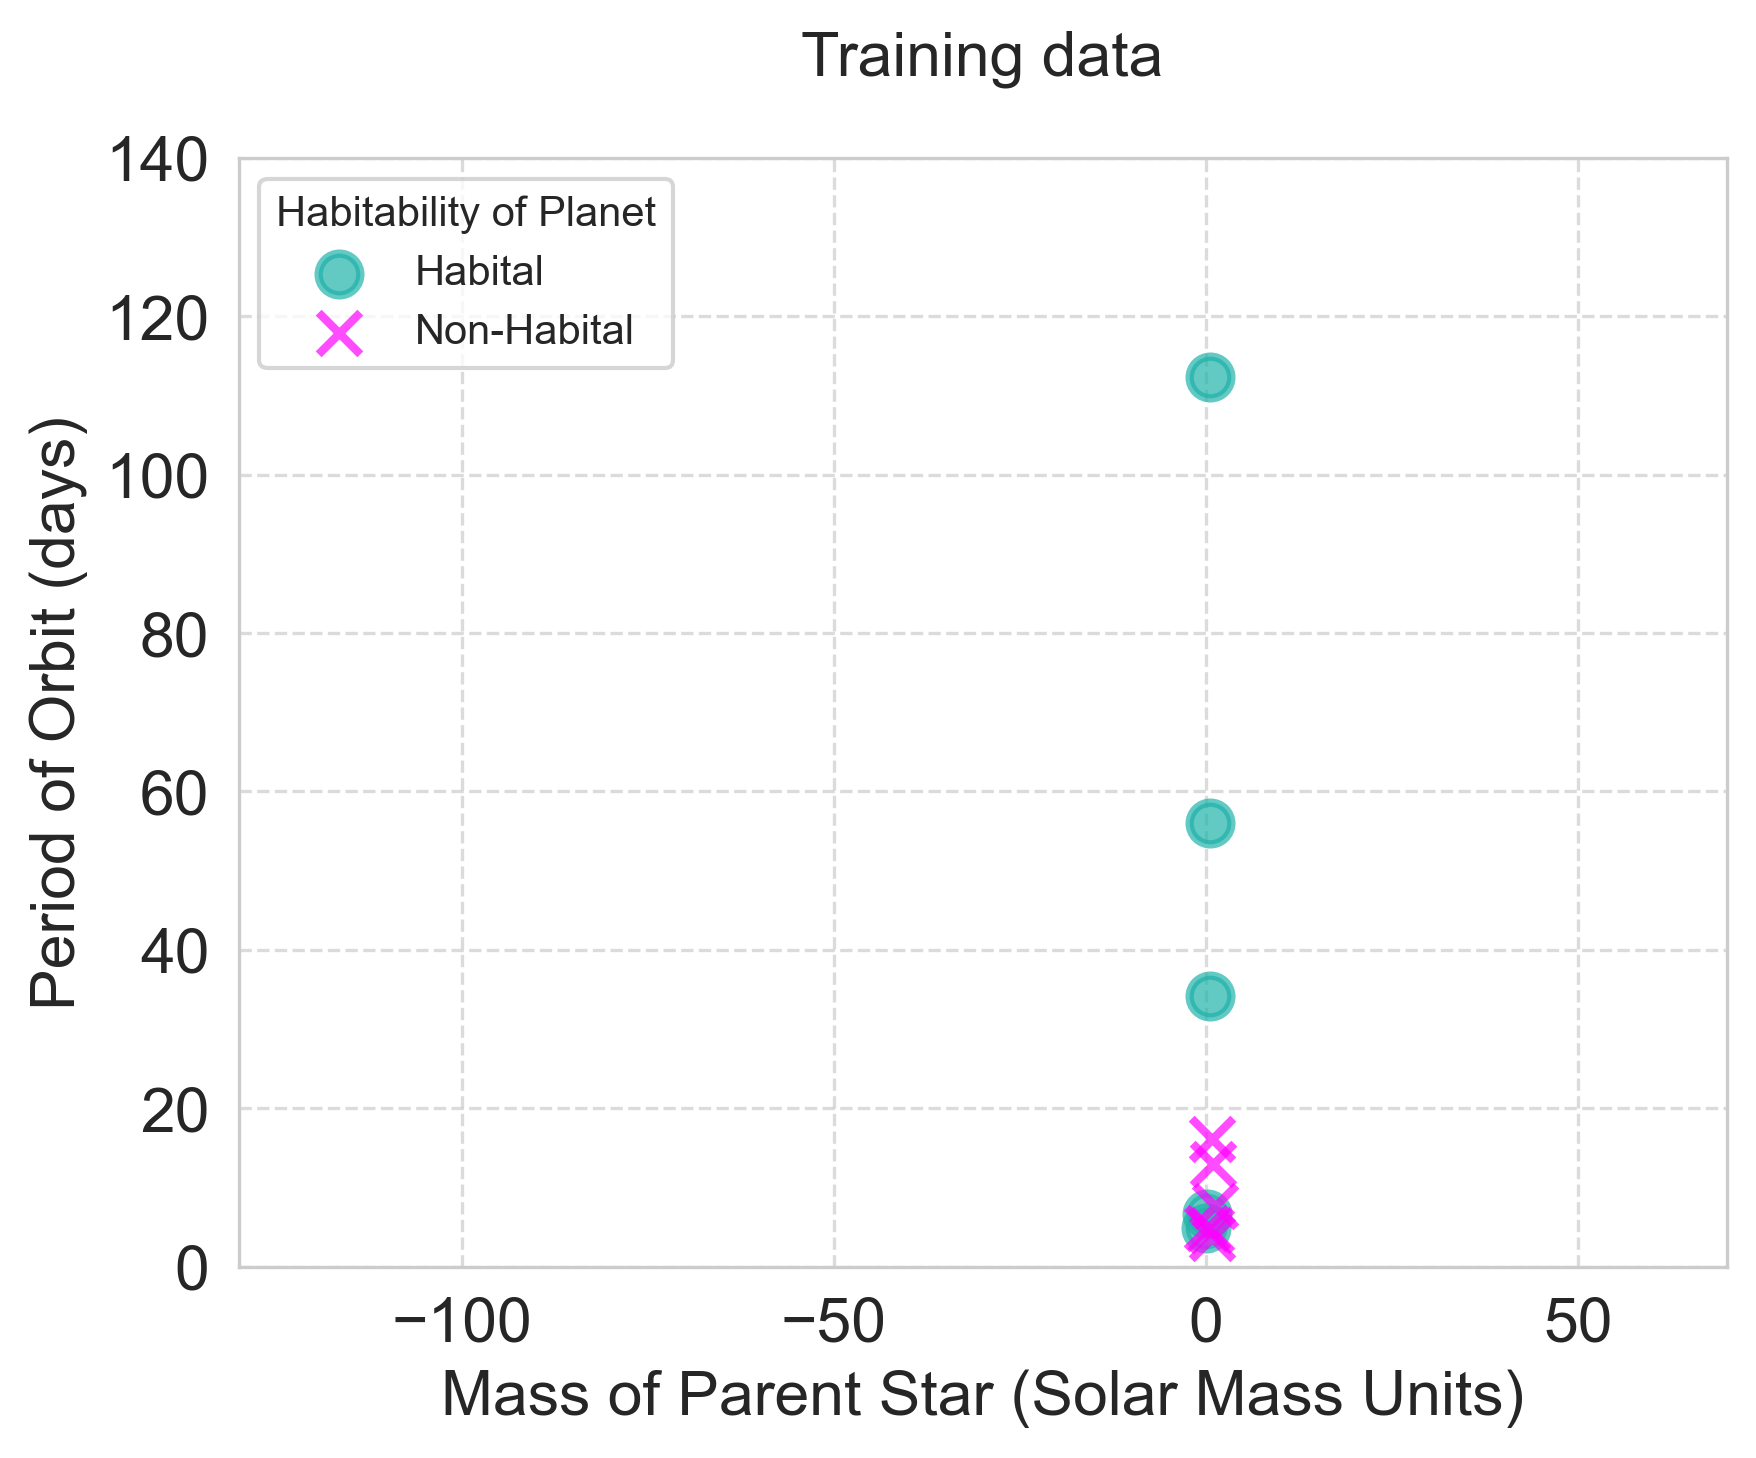

In [15]:
# plot trainings dataset
plot_planet_data(df_train, title="Training data", save_plot=True)

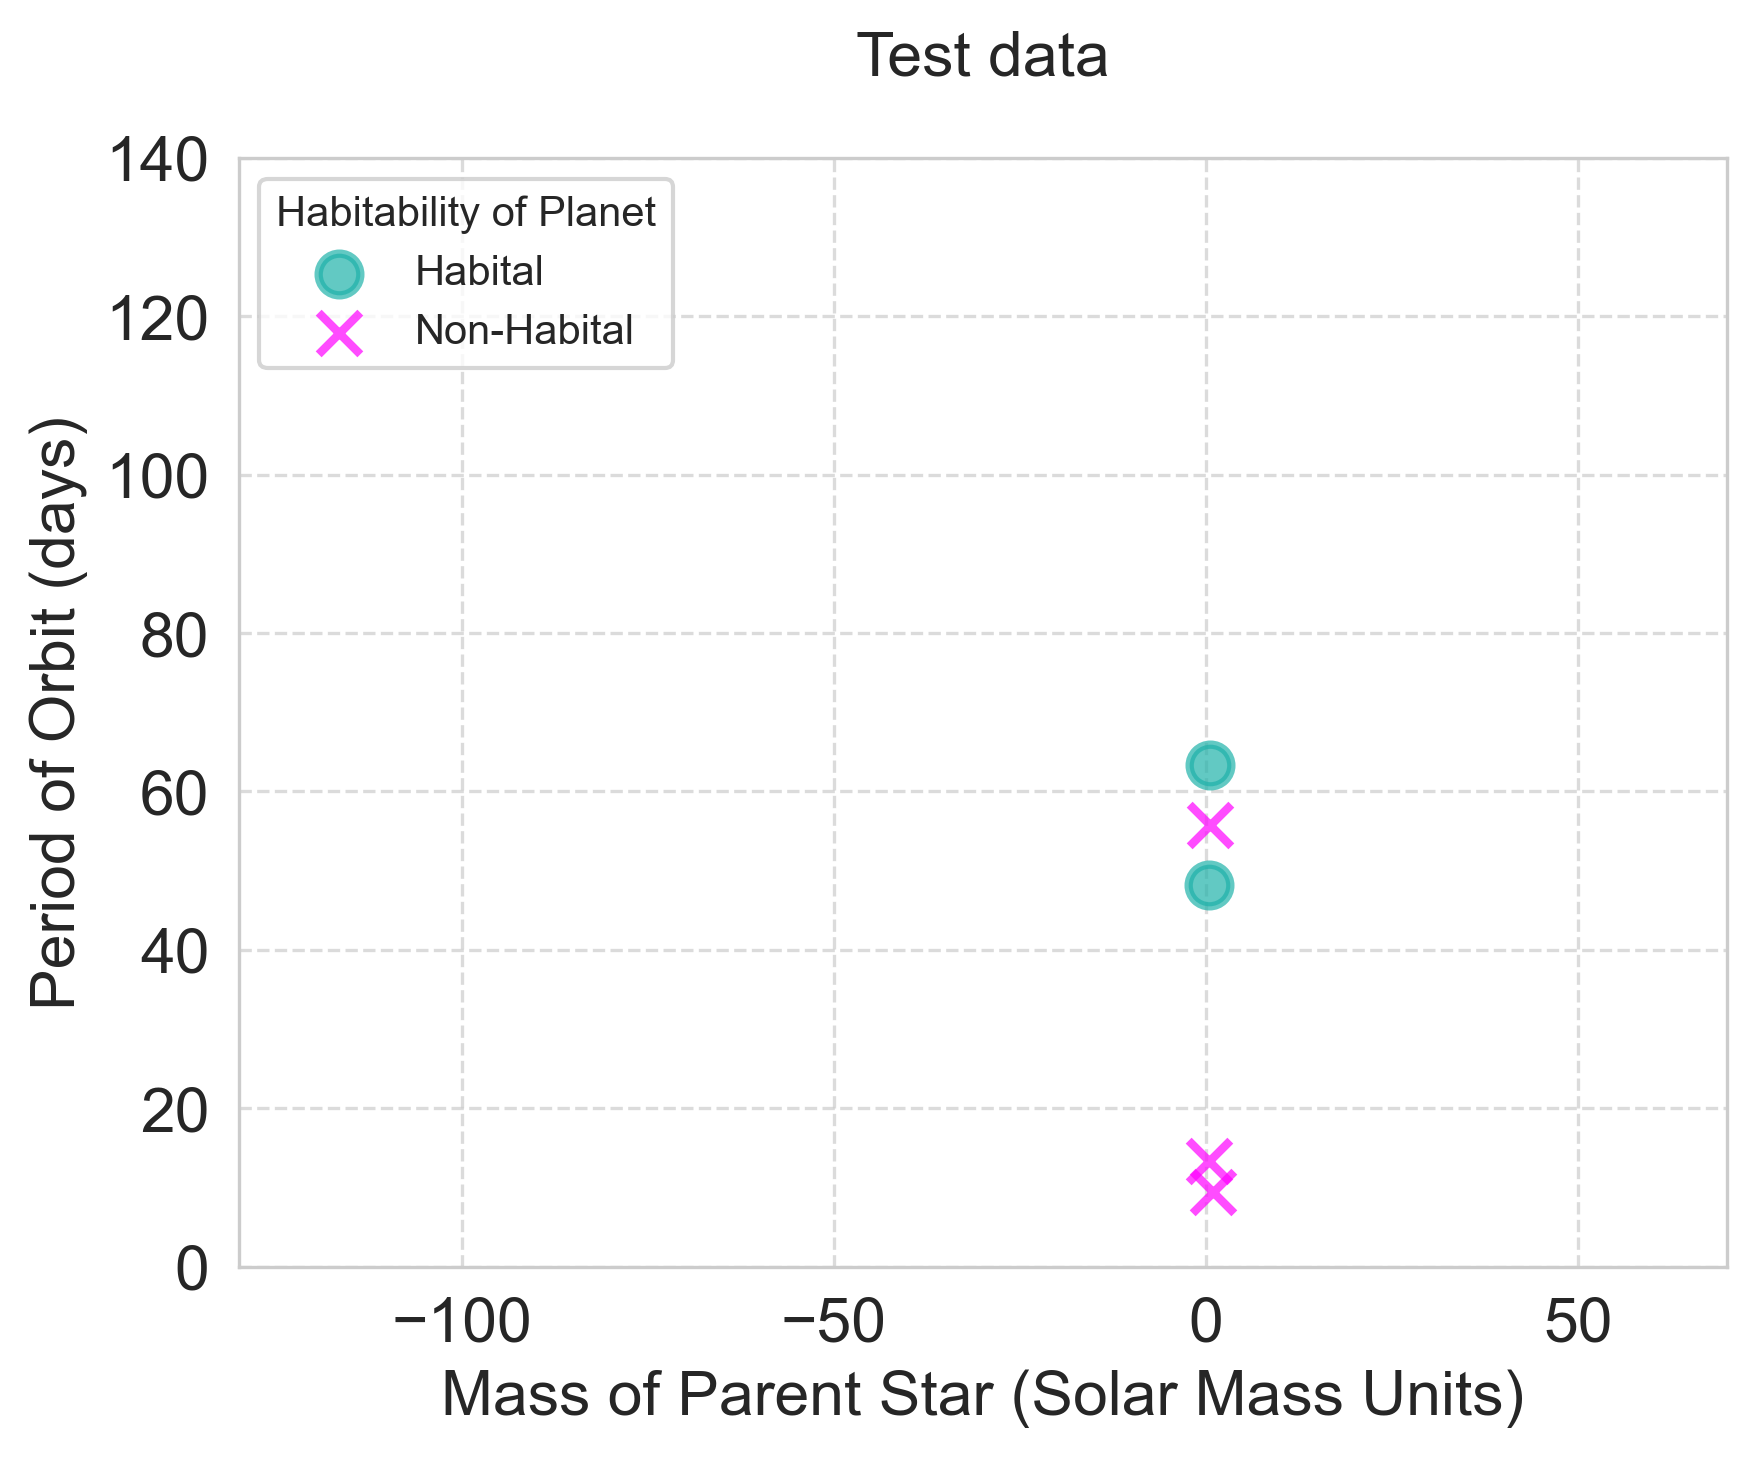

In [16]:
# plot test dataset
plot_planet_data(df_test, title="Test data", save_plot=True)

In [17]:
def plot_planet_data_distance(df, title='', save_plot=False):
    """
    plot_planet_data_distance() - make a nice plot of 
    dataset, using target for marker and colors
    
    Arguments
        - df, DataFrame: a dataframe with the target ('P_HABITABLE') included.
        - save_plot, bool: True - save plot in file, default=False
    """
    for outcome, color, marker, size in [
        (1, '#20B2AA', 'o', 100),  # Blue-ish bubbles for habitable planet
        (0, '#FF00FF', 'x', 100)  # Magenta crosses for not-habitable planet
    ]:
        mask = df['P_HABITABLE'] == outcome
        # use two features: S_MASS and P_PERIOD
        plt.scatter(df[mask]['S_MASS'], 
                #df[mask]['P_PERIOD'],
                df[mask]['P_DISTANCE'],
                c=color,
                marker=marker,
                s=size,
                label="Habital" if outcome == 1 else "Non-Habital",
                alpha=0.7,
                linewidth=2)  # Make the markers thicker
        #a = plt.scatter(TrainSet['S_MASS'], TrainSet['P_PERIOD'], marker = '*',facecolor = 'none',\
        #    c = TrainSet['P_HABITABLE'], s = 100, label = 'Train', cmap=cmap) 
    
    plt.title(title, pad=20, size=12)
    plt.xlabel('Mass of Parent Star (Solar Mass Units)', size=15)
    plt.ylabel('Distaince planet (AU)', size=15)
    plt.legend(title='habitable/non-habitable of Planet', title_fontsize=10, fontsize=10, loc="upper left")

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust axis limits to add some padding
    #plt.xlim(-130,70)
    plt.ylim(0,1)

    if save_plot:
        plt.savefig(f"images/HabPlanets_{title.replace(' ' , '')}_Distance.png", dpi = 250)

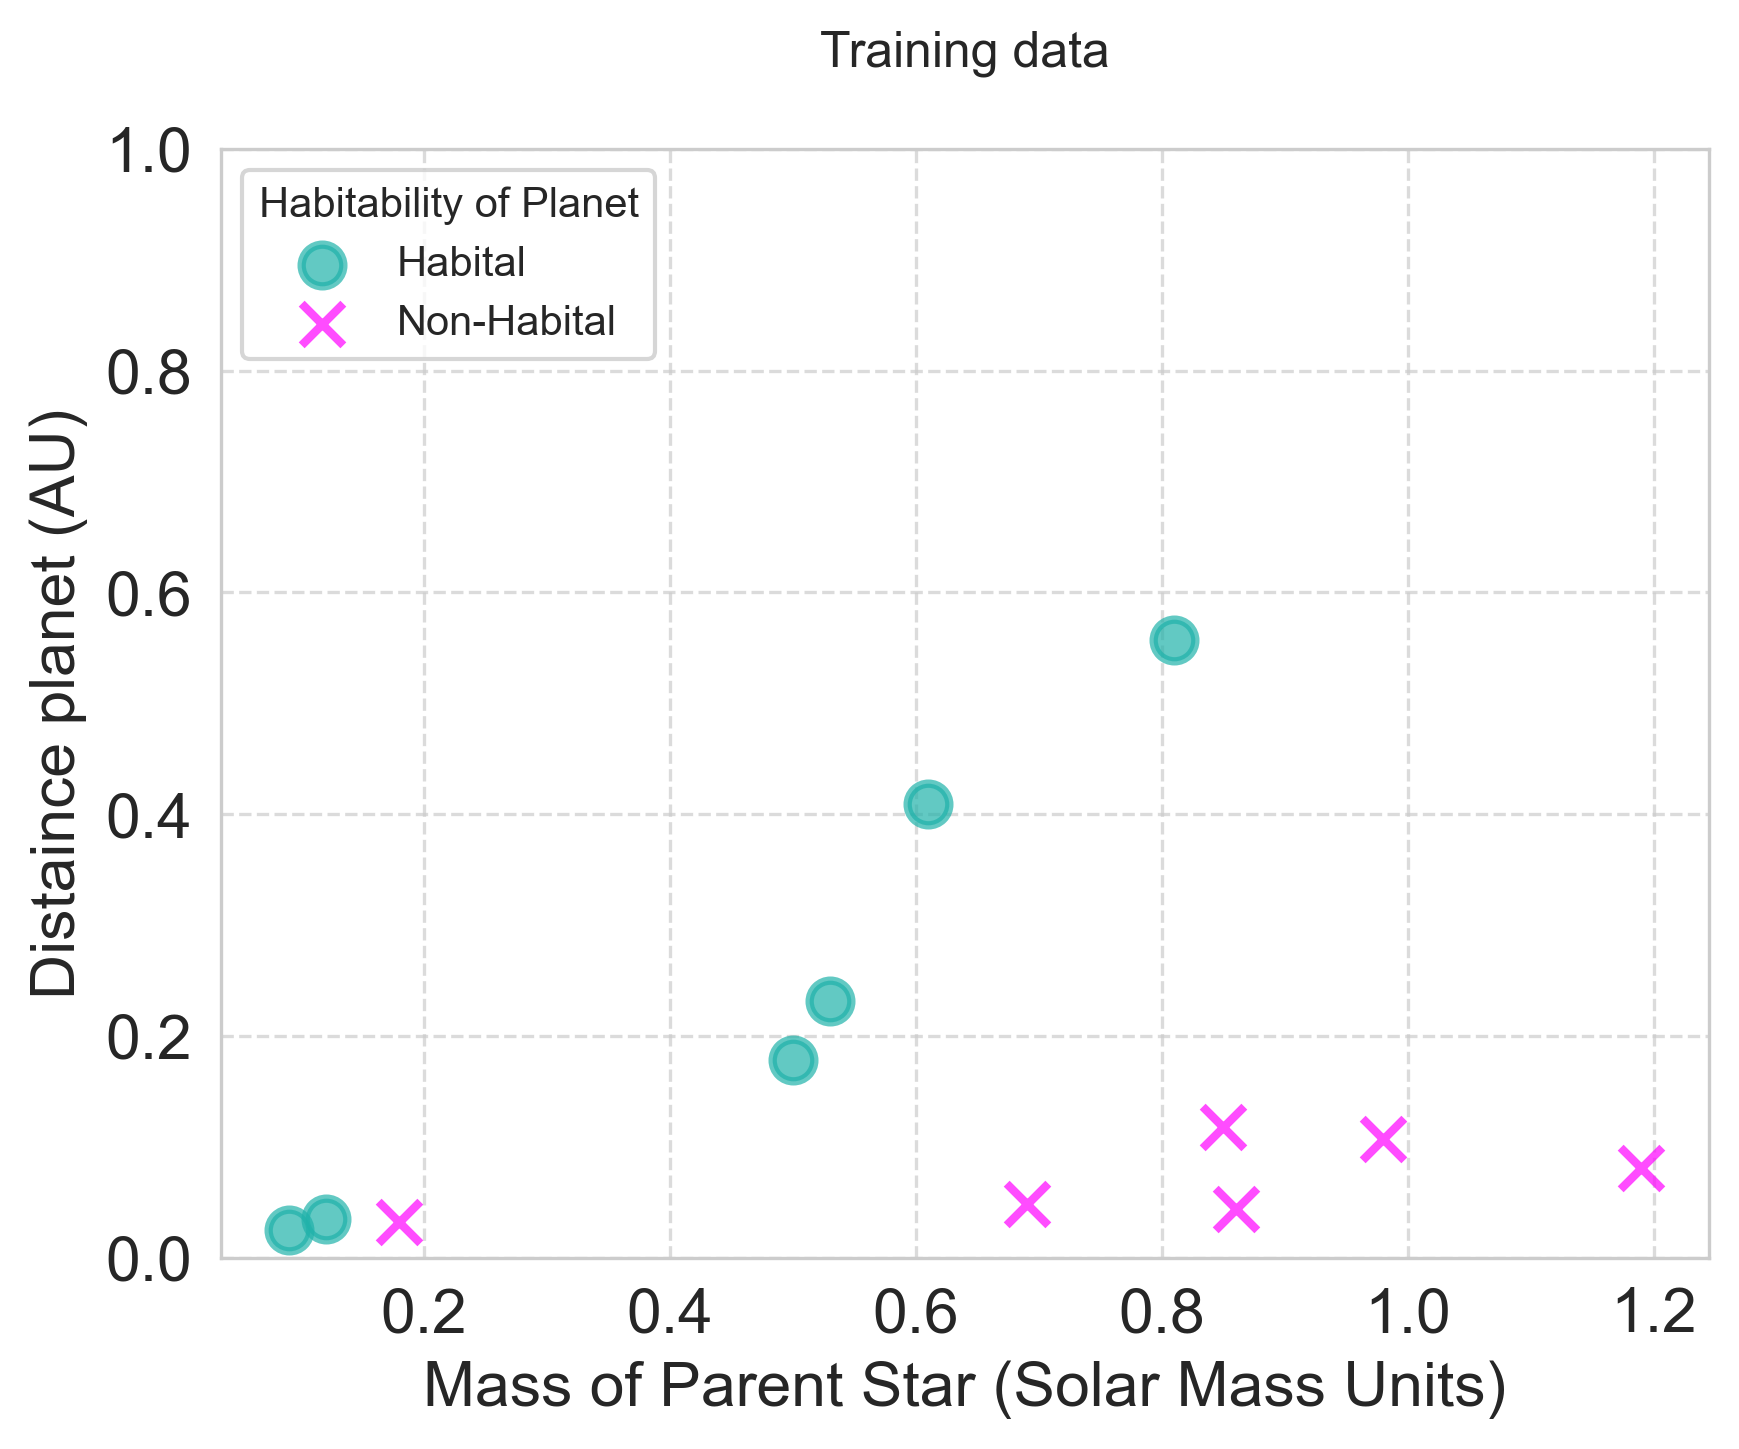

In [18]:
# plot training dataset
plot_planet_data_distance(df_train, title="Training data", save_plot=True)

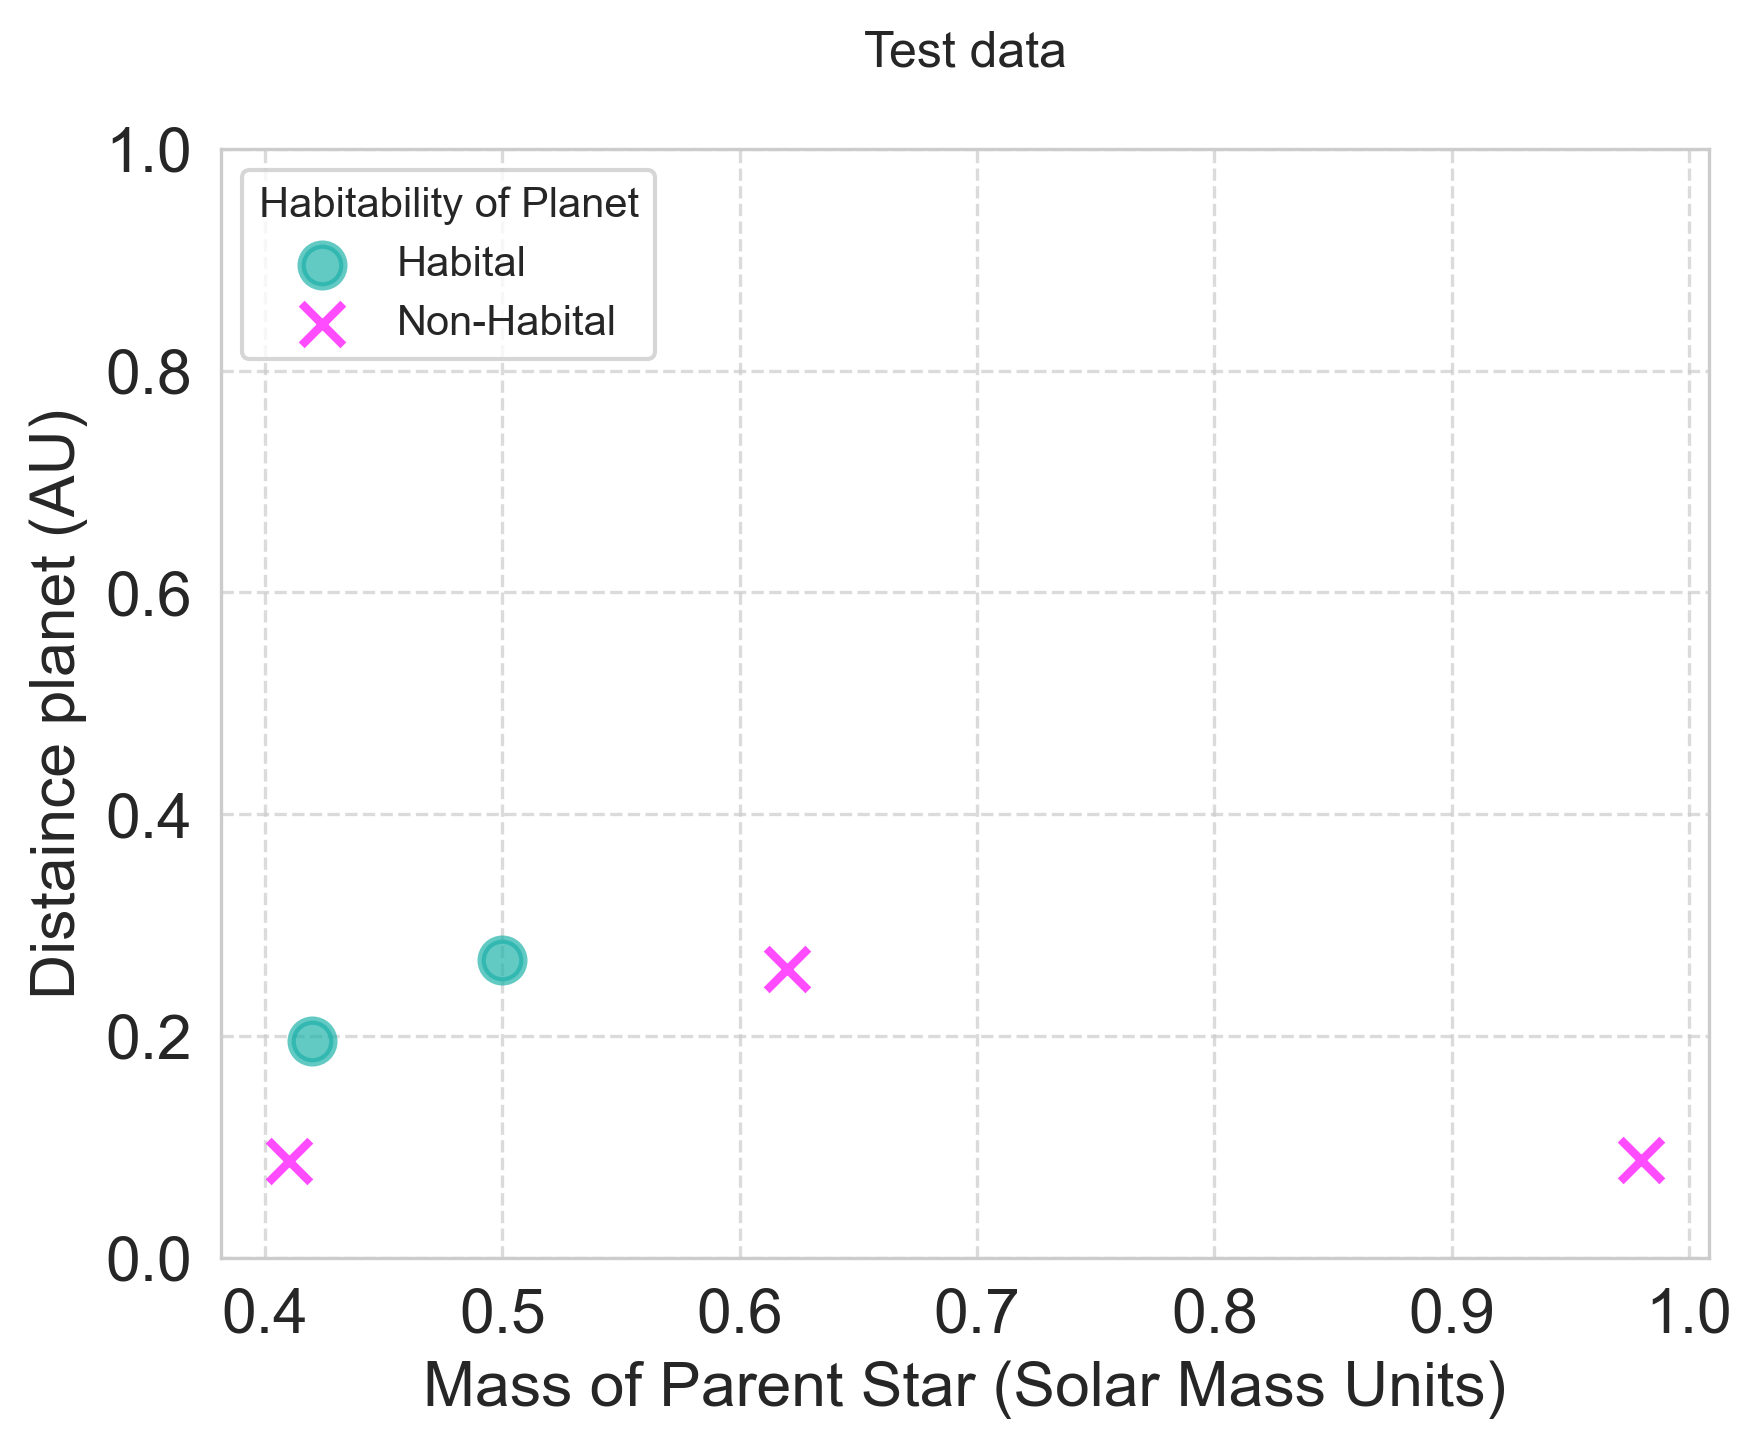

In [19]:
# plot test dataset
plot_planet_data_distance(df_test, title="Test data", save_plot=True)

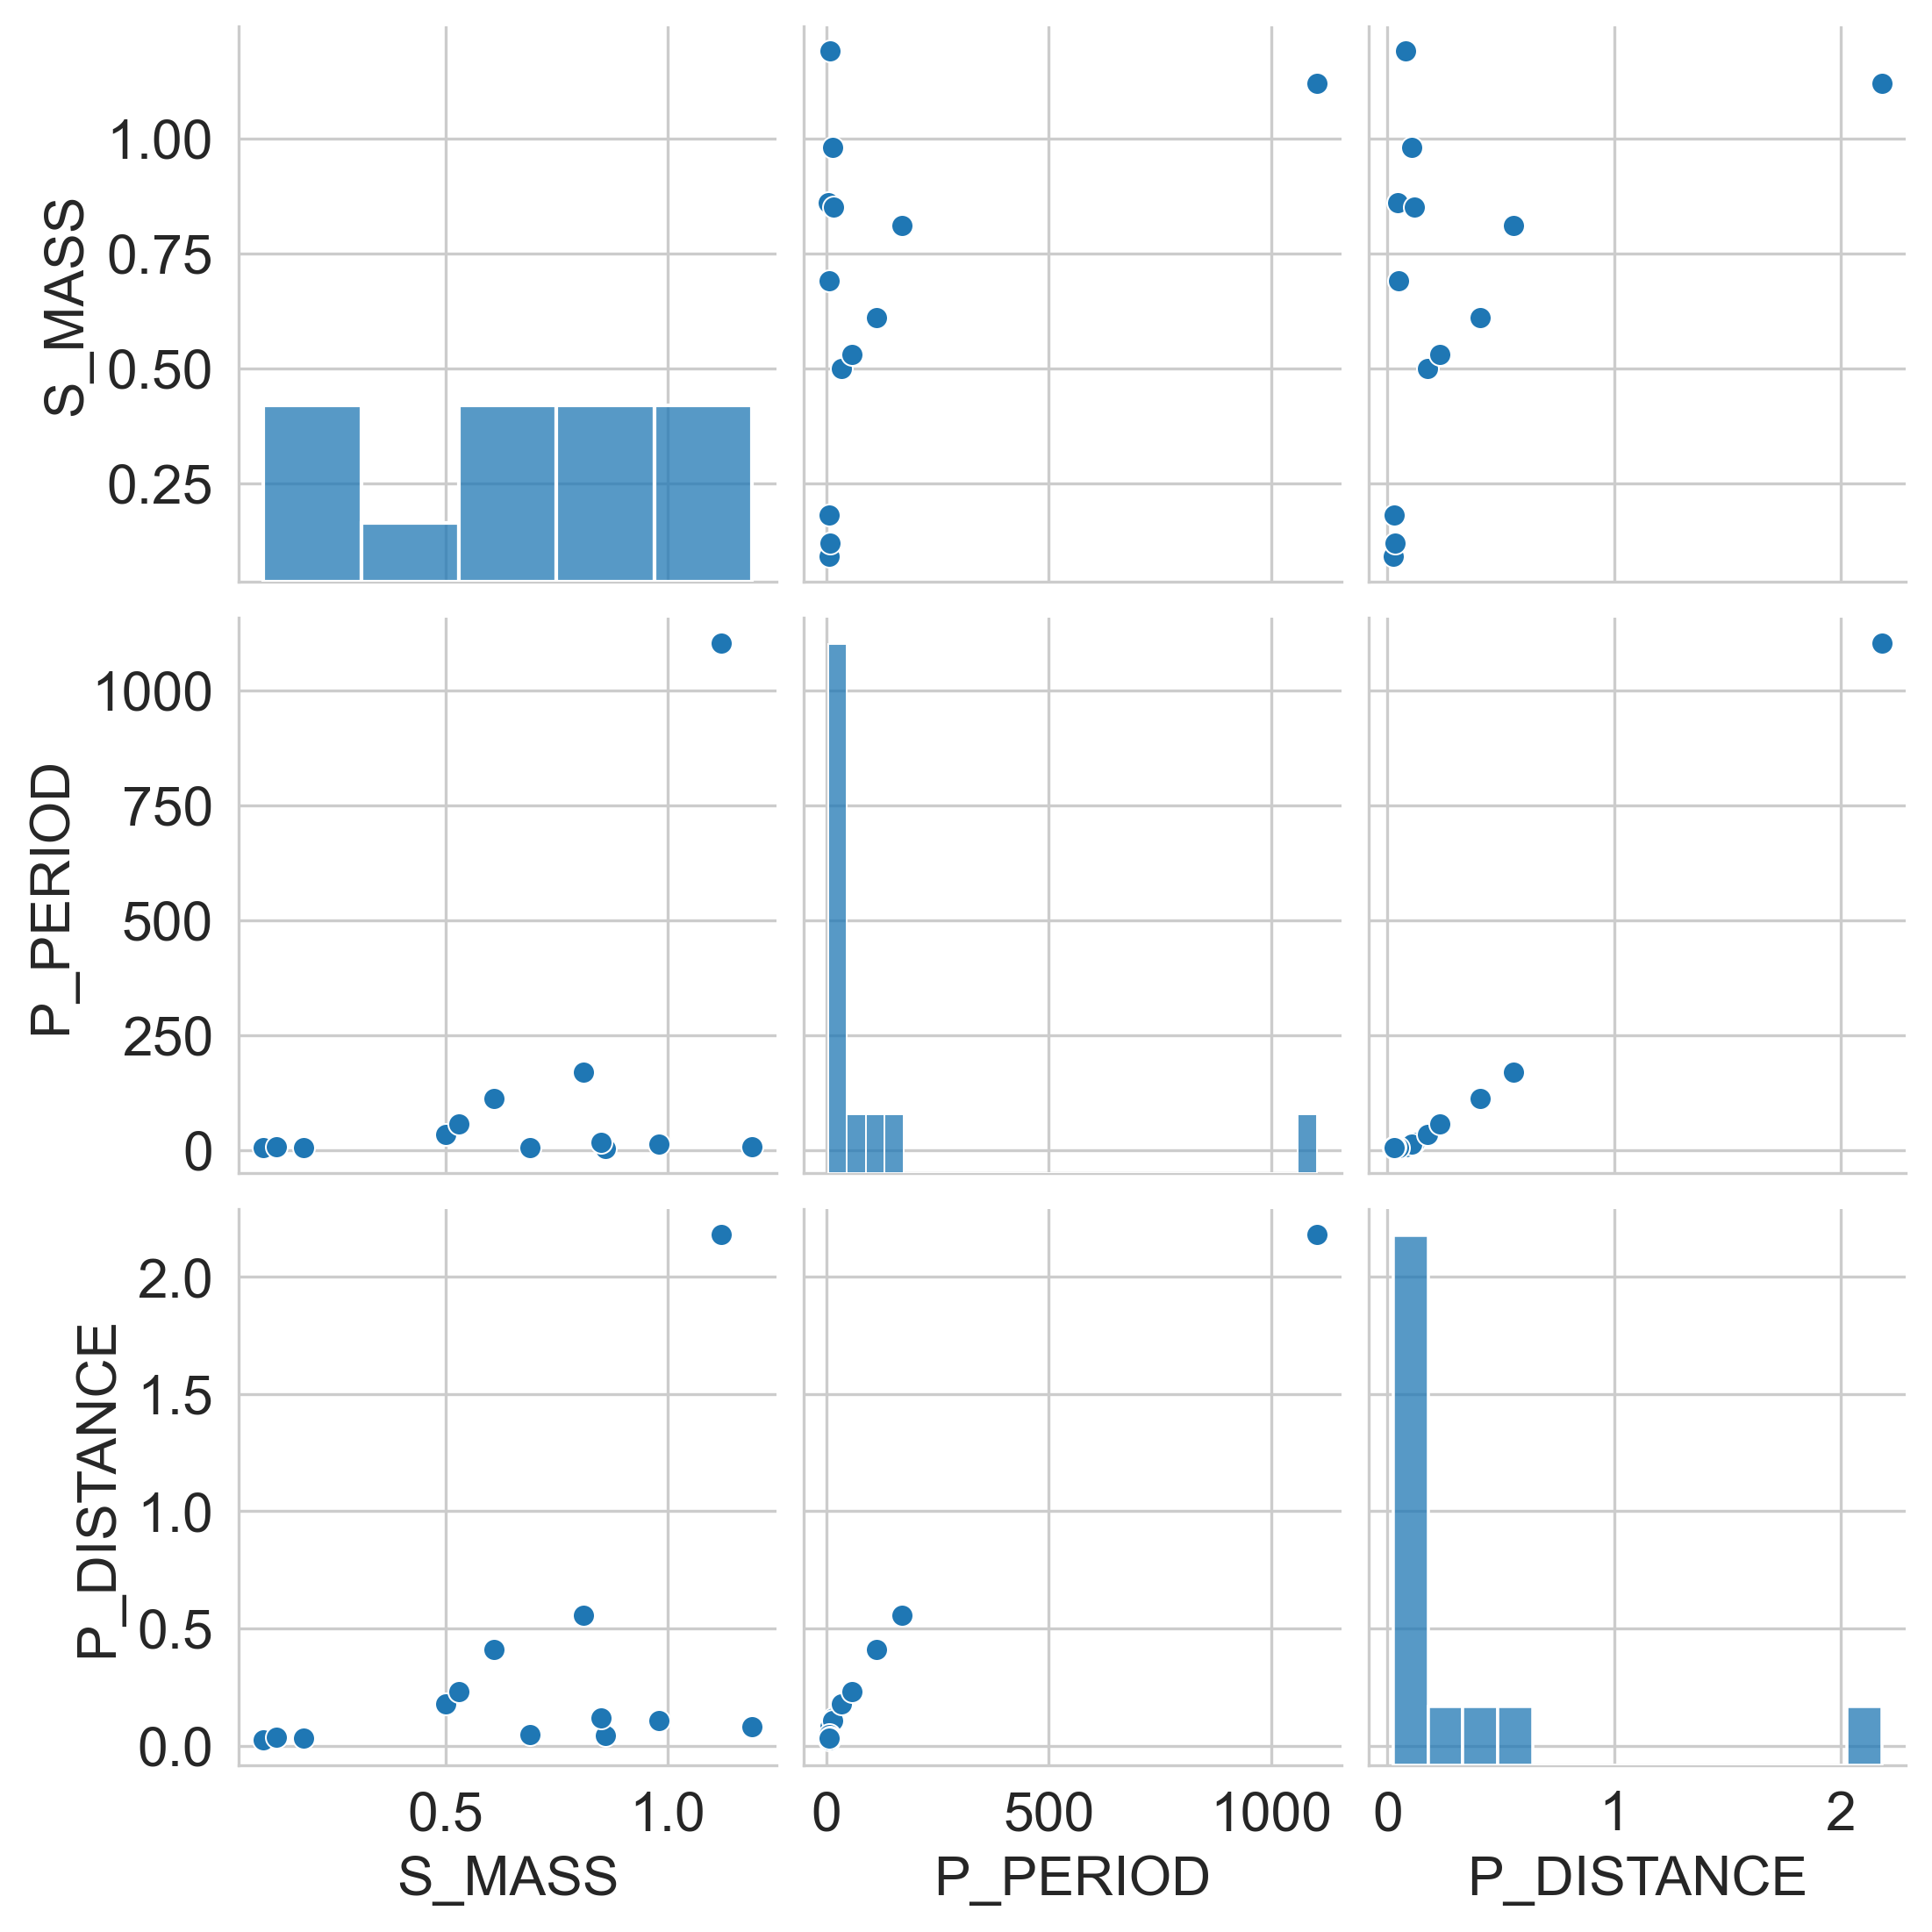

In [22]:
# pairplot - using Seaborn
# pairplot - plot a grid of pairwise relationship in dataset.
sns.pairplot(Xtrain)

/var/folders/hf/ng1p0grj0856xq22fg1l1dg80000gn/T/ipykernel_12502/1930758570.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix(Xtrain, alpha=1, ax=ax)


array([[<Axes: xlabel='S_MASS', ylabel='S_MASS'>,
        <Axes: xlabel='P_PERIOD', ylabel='S_MASS'>,
        <Axes: xlabel='P_DISTANCE', ylabel='S_MASS'>],
       [<Axes: xlabel='S_MASS', ylabel='P_PERIOD'>,
        <Axes: xlabel='P_PERIOD', ylabel='P_PERIOD'>,
        <Axes: xlabel='P_DISTANCE', ylabel='P_PERIOD'>],
       [<Axes: xlabel='S_MASS', ylabel='P_DISTANCE'>,
        <Axes: xlabel='P_PERIOD', ylabel='P_DISTANCE'>,
        <Axes: xlabel='P_DISTANCE', ylabel='P_DISTANCE'>]], dtype=object)

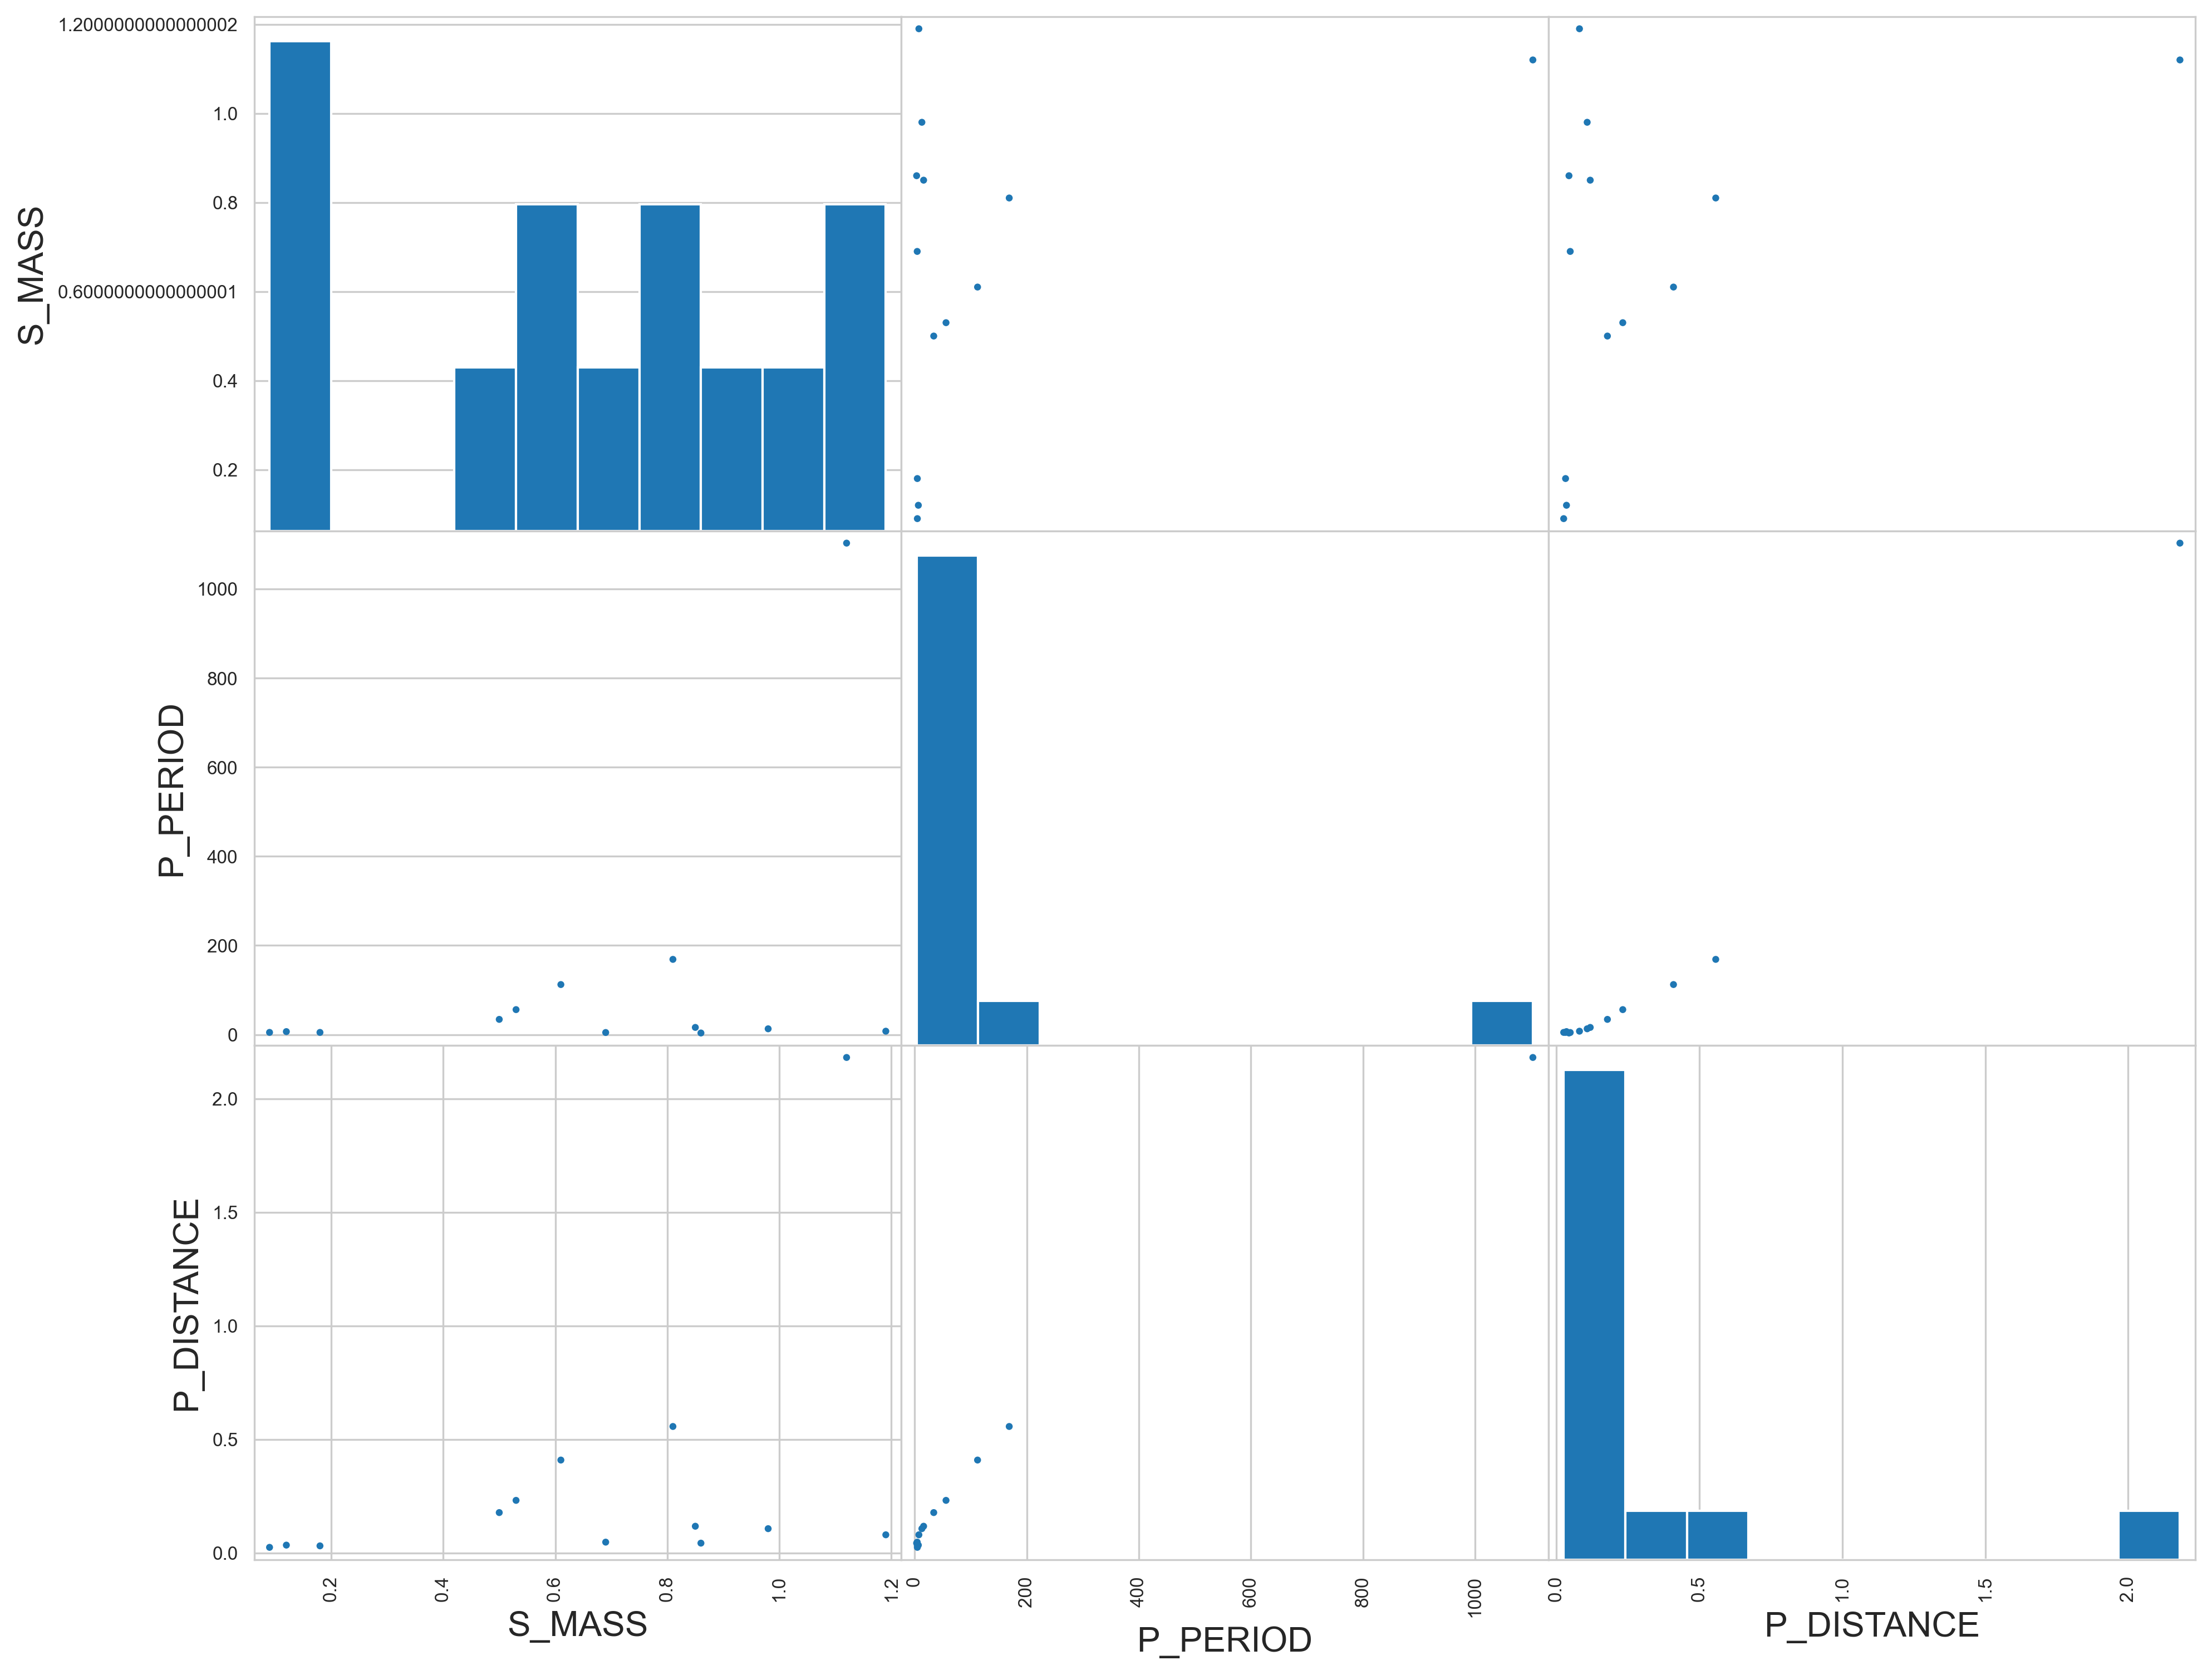

In [23]:
from pandas.plotting import scatter_matrix

fig, ax = plt.subplots(figsize=(15,12))
scatter_matrix(Xtrain, alpha=1, ax=ax)

---
## Part 2 - Scaled datasets

#### Scaling data

The `Solar Mass` and the `Period` have very different ranges. That is visible in above plots as a more or less vertical line: Mass range is much smaller than Period ranges - see also Data Summary Statistics. 

For an algorithm like kNN, which depends on **distances**, the feature with the largest numerical values will dominate. This unwanted behavior can be solved by normalizing the features and bringing them to similar numerical ranges.

The simplest version of standardization involves calculating the **mean** and **standard deviation** of each feature, and modify alle values by subtracting the mean and divide the result by the standard deviation.

However, because the mean is sensitive to outliers, we adopt a more robust scaling technique that sets the **median** (instead of the mean) to zero and the **difference between the 25% and 75% percentiles** (instead of the standard deviation).

This is achieved by creating a `RobustScaler` object provided by the `preprocessing` class in `sklearn` fitting it to the training set to derive the desired scaling transformation, and then applying this transformation to the training set and test set.

#### 2. Scale the datasets

Helper functions:
- a plot function for scaled dataframe
- a scale dataset function, using a scaler

Visualize datasets using different scalers
- 2.2 using RobustScaler
- 2.3 using Min-Max Normalization

#### 2 Helper functions


In [54]:
# helper: plot function for scaled dataset
# modified plot function of Thu Vu
def plot_planet_scaled_data(df, xlim, ylimit, title="", save_plot=False):
    """
    plot_planet_data() - make a nice plot of a dataset, 
    using target for marker and colors
    
    Arguments
        - df, DataFrame: a dataframe with the target ('P_HABITABLE') included.
        - xlimit, tuple: x-axis limits
        - ylimit, tuple: y-axis limits
        - save_plot, bool: True - save plot in file, default=False
    """
    for outcome, color, marker, size in [
        (1, '#20B2AA', 'o', 100),  # Green bubbles for habitable planet
        (0, '#FF00FF', 'x', 100)  # Magenta crosses for not-habitable planet
    ]:
        mask = df['P_HABITABLE'] == outcome
        plt.scatter(df[mask]['S_MASS'], 
                df[mask]['P_PERIOD'],
                c=color,
                marker=marker,
                s=size,
                label="Habital" if outcome == 1 else "Non-Habital",
                alpha=0.7,
                linewidth=2)  # Make the markers thicker
    
    plt.title(title, pad=20, size=15)
    plt.xlabel('Mass of Parent Star (Solar Mass Units)')  #, size=10)
    plt.ylabel('Period of Orbit (days)') #, size=10)
    plt.legend(title='habitable/non-habitable of Planet', title_fontsize=10, fontsize=10, loc="upper left")

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust axis limits to add some padding
    plt.xlim(xlimit[0],xlimit[1])
    plt.ylim(ylimit[0],ylimit[1])

    if save_plot:
        plt.savefig('images/HabPlanets_Scaled_{title.replace(' ' , '')}.png', dpi = 250)

In [55]:
# helper to scale a dataframe
def scale_data(df, scaler):
    print(f"1. Original dataset df:\n{df.head()}")
    print("-------------")
    
    # we cannot use the P_NAME column for scaling
    df_copy = df.drop('P_NAME', axis=1)
    print(f"2. Preprocessed set df_copy:\n{df_copy.head()}")
    print("-------------")
    
    # scale the preprocessed training dataframe
    # 1. fit_tranform() requires numpy-arrays
    transformed = scaler.fit_transform(df_copy.to_numpy())
    # 2. map transformed back into a dataframe
    df_scaled = pd.DataFrame(
        transformed,
        columns=df_copy.columns)
    print(f"3. Scaled set df_scaled:\n{df_scaled.head()}")
    print("-------------")
    
    # add planet names, using either pd.concat() or df.join()
    #df_train_scaled_withname = pd.concat([
    #    df_train_scaled, df_train.P_NAME], axis=1)
    df_scaled = df_scaled.join(
        df.P_NAME)
    print(f"Scaled set with planet name df_scaled:\n{df_scaled.head()}")
    print("-------------")
    return df_scaled 


#### 2.2 RobustScaler

Note: some scaled values are negative, while I expected only positieve values between 0 and 1.0

Scaler: RobustScaler()
1. Original dataset df:
         P_NAME  S_MASS    P_PERIOD  P_DISTANCE  P_HABITABLE
0  Kepler-736 b    0.86    3.601472    0.043718            0
1  Kepler-636 b    0.85   16.080661    0.118082            0
2  Kepler-887 c    1.19    7.638460    0.080420            0
3  Kepler-442 b    0.61  112.305300    0.409327            1
4  Kepler-772 b    0.98   12.992073    0.107408            0
-------------
2. Preprocessed set df_copy:
   S_MASS    P_PERIOD  P_DISTANCE  P_HABITABLE
0    0.86    3.601472    0.043718            0
1    0.85   16.080661    0.118082            0
2    1.19    7.638460    0.080420            0
3    0.61  112.305300    0.409327            1
4    0.98   12.992073    0.107408            0
-------------
3. Scaled set df_scaled:
     S_MASS  P_PERIOD  P_DISTANCE  P_HABITABLE
0  0.472222 -0.183604   -0.338402          0.0
1  0.444444  0.060388    0.056715          0.0
2  1.388889 -0.104673   -0.143397          0.0
3 -0.222222  1.941757    1.604177  

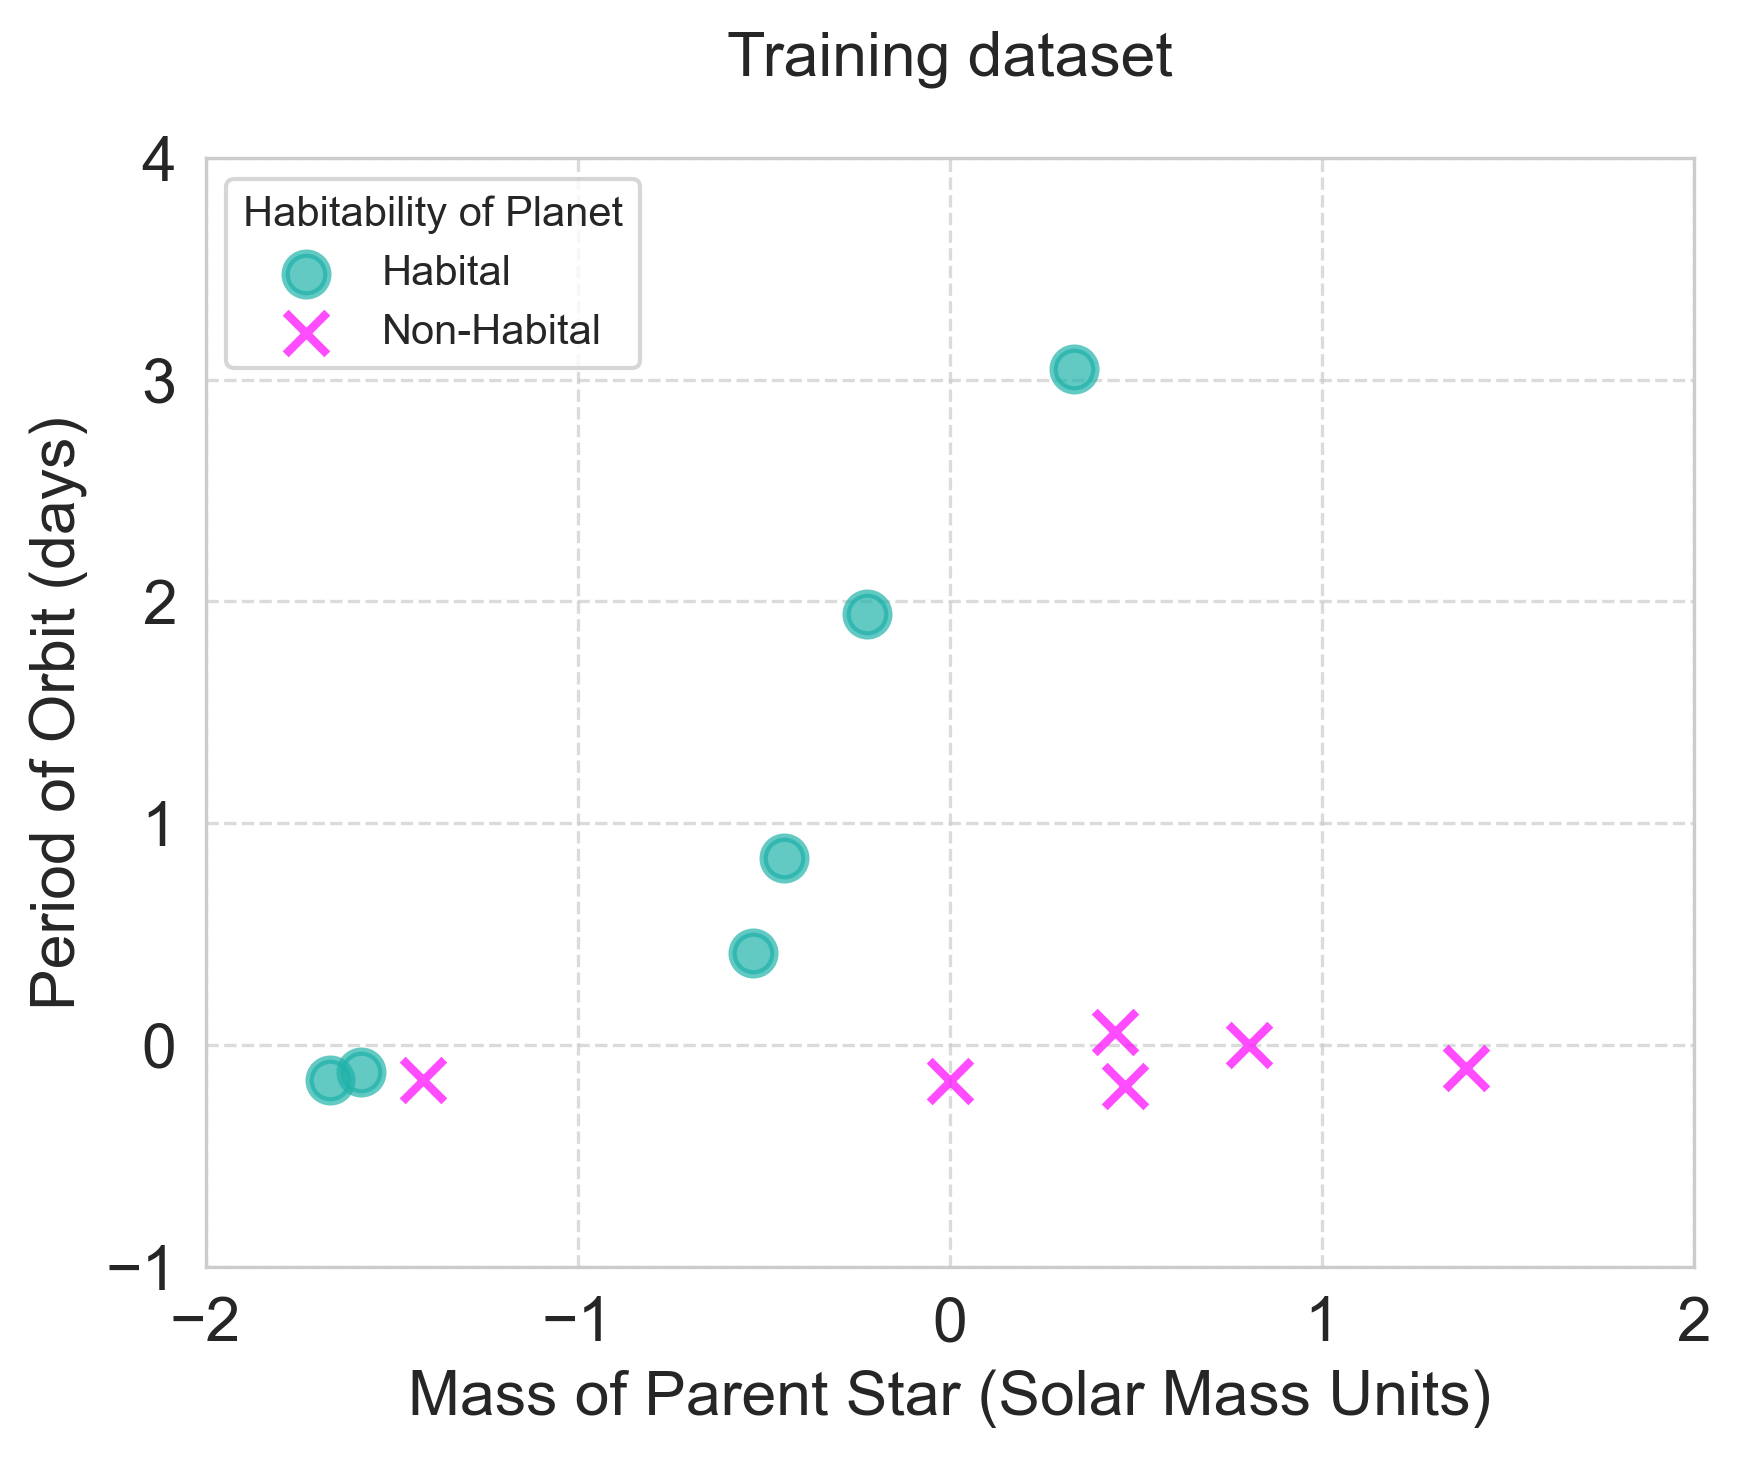

In [56]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
print(f"Scaler: {scaler}")

# scale dataset df_train
df_train_scaled = scale_data(df_train, scaler)

# RobustScaler limits
xlimit = (-2.0, 2.0)
ylimit = (-1.0, 4.0)

plot_planet_scaled_data(df_train_scaled,
                 xlimit, ylimit, 
                 title="Training dataset",
                 save_plot=True)

#### 2.3 MinMaxScaler


Scaler: MinMaxScaler()
1. Original dataset df:
         P_NAME  S_MASS    P_PERIOD  P_DISTANCE  P_HABITABLE
0  Kepler-736 b    0.86    3.601472    0.043718            0
1  Kepler-636 b    0.85   16.080661    0.118082            0
2  Kepler-887 c    1.19    7.638460    0.080420            0
3  Kepler-442 b    0.61  112.305300    0.409327            1
4  Kepler-772 b    0.98   12.992073    0.107408            0
-------------
2. Preprocessed set df_copy:
   S_MASS    P_PERIOD  P_DISTANCE  P_HABITABLE
0    0.86    3.601472    0.043718            0
1    0.85   16.080661    0.118082            0
2    1.19    7.638460    0.080420            0
3    0.61  112.305300    0.409327            1
4    0.98   12.992073    0.107408            0
-------------
3. Scaled set df_scaled:
     S_MASS  P_PERIOD  P_DISTANCE  P_HABITABLE
0  0.700000  0.000000    0.008590          0.0
1  0.690909  0.011351    0.043085          0.0
2  1.000000  0.003672    0.025615          0.0
3  0.472727  0.098876    0.178185  

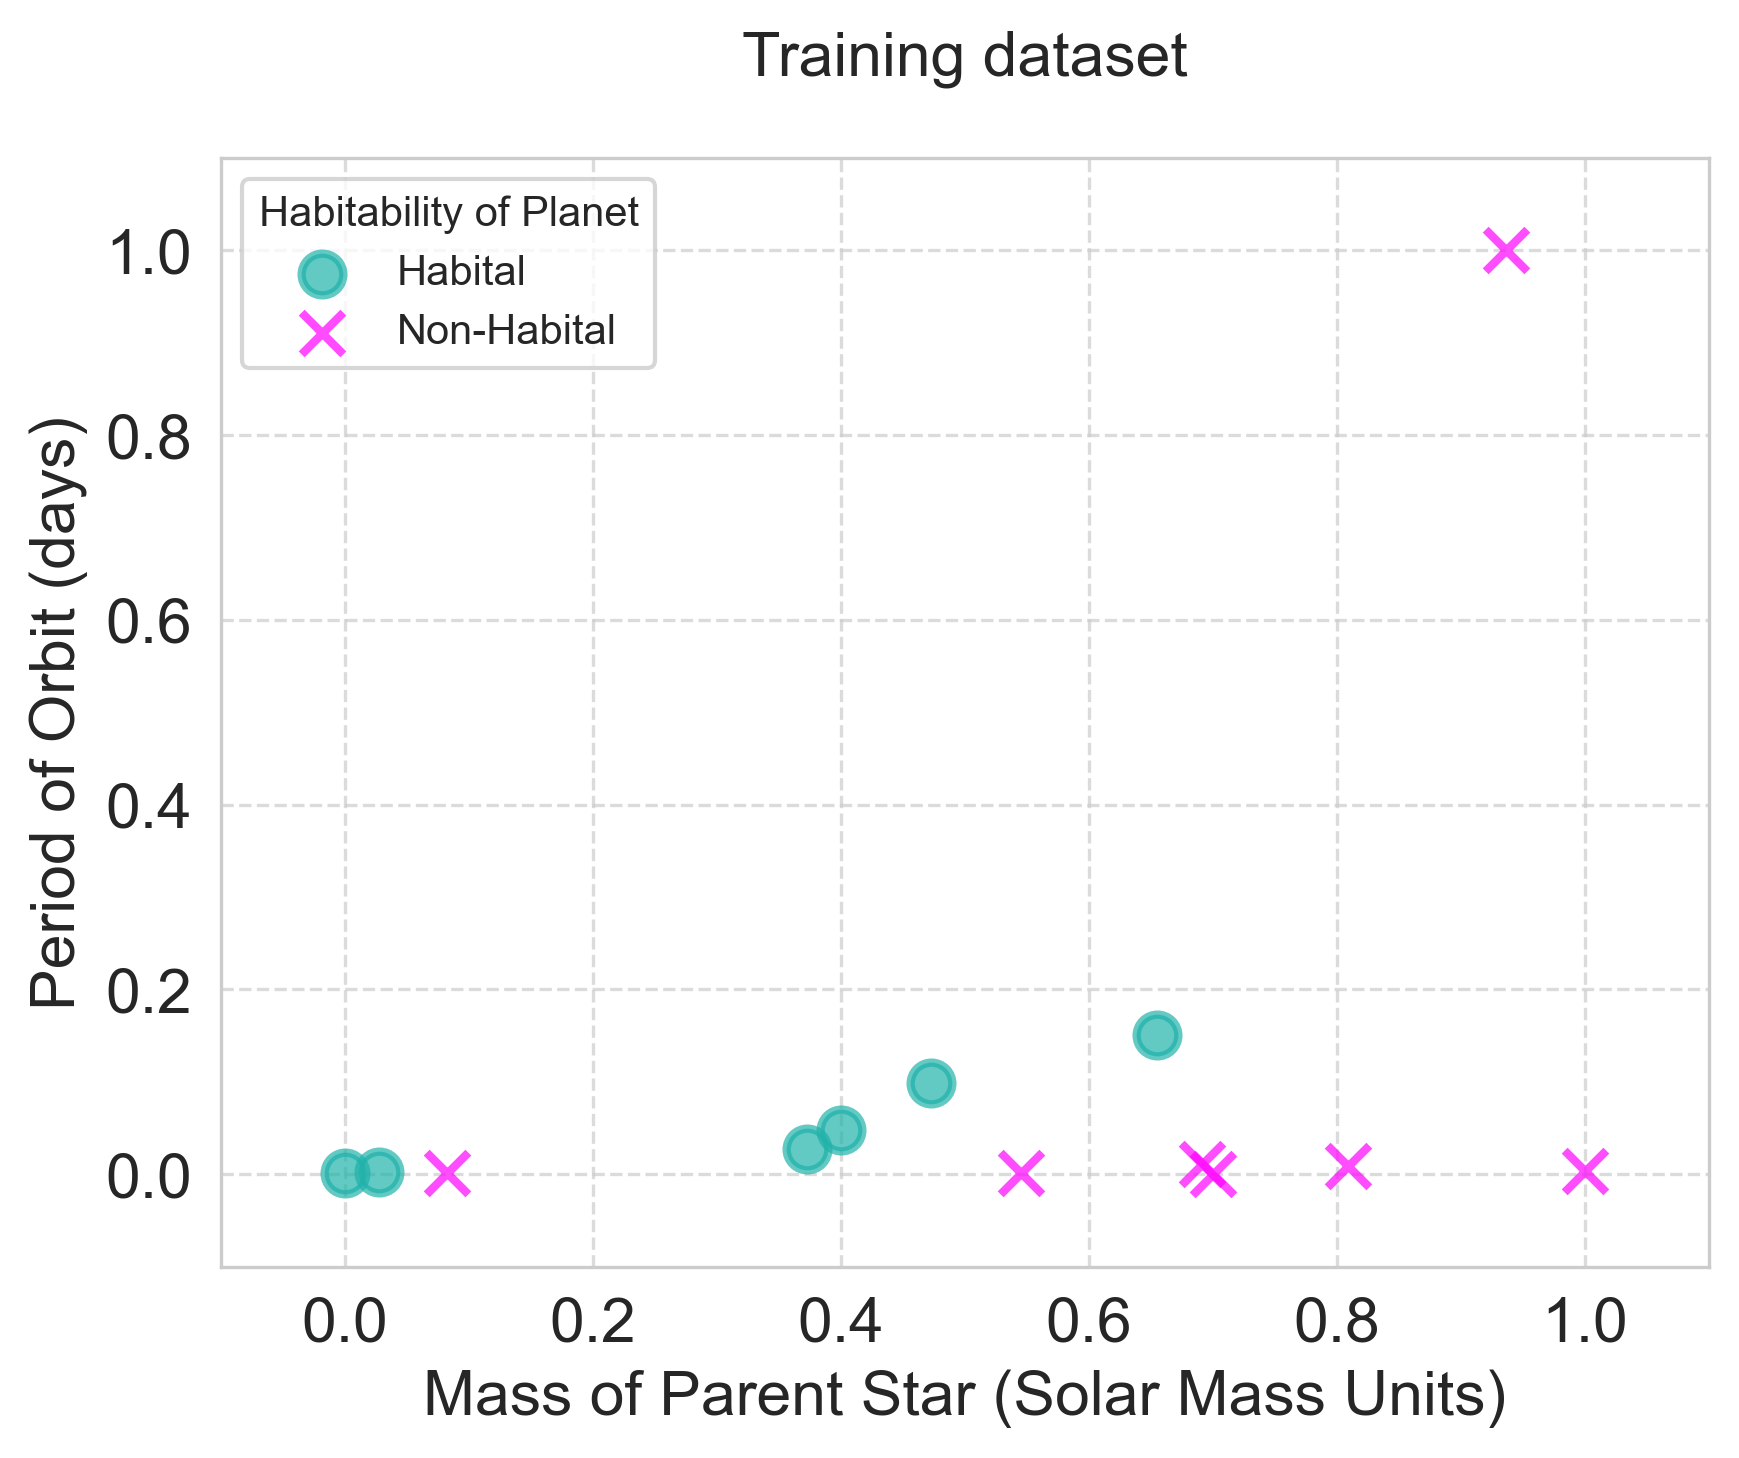

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(f"Scaler: {scaler}")

# scale dataset df_train
df_train_scaled = scale_data(df_train, scaler)

# axis limits for scaled data:
xlimit = (-0.1, 1.1)
ylimit = (-0.1, 1.1)

plot_planet_scaled_data(df_train_scaled,
                 xlimit, ylimit, 
                 title="Training dataset",
                 save_plot=True)

<hr>

# 2025-0606 TODO

#### Scaling the Test dataset

In [ ]:
print(f"Scaler: {scaler}")

print(f"1. Original testset df_test:\n{df_test.head()}")
print("-------------")

# we cannot use the P_NAME column for scaling,
# removing P_HABITABLE column (because it's uselsss) 
# DOES NOT WORK: joining the column lateron -> NaN ?????
#df_test_copy = df_test.drop(['P_NAME', 'P_HABITABLE'], axis=1)
df_test_copy = df_test.drop('P_NAME', axis=1)
print(f"2. Copied testset df_test_copy:\n{df_test_copy.head()}")
print("-------------")

# scale the (copied) testset
df_test_scaled = scaler.fit_transform(df_test_copy.to_numpy())
df_test_scaled = pd.DataFrame(
    df_test_scaled,
    columns=df_test_copy.columns)
print(f"3. Scaled testset df_test_scaled:\n{df_test_scaled.head()}")
print("-------------")

# add back column 'P_HABITABLE' 
# DOES NOT WORK: joining the column -> NaN ?????
#df_test_scaled = df_test_scaled.join(df_test.P_HABITABLE)
#print(f"4. Scaled testset df_test_scaled:\n{df_test_scaled.head()}")
#print("-------------")

# OPTIONAL: add planet names, using either pd.concat() or df.join()
# DOES NOT WORK: adding -> NaN ????
#df_test_scaled_withname = pd.concat(
#    [df_test_scaled, df_test.P_NAME],
#    axis=1)
#df_test_scaled_withname = df_test_scaled.join(df_test.P_NAME)
#print(f"Scaled testset with planet name df_test_scaled_withname:\n{df_test_scaled_withname.head()}")
#print("-------------")

In [ ]:
# axis limits for scaled data:
#xlimit = (-2.5,2.5)
#ylimit = (-1.,2.5)

# axis limits for non-scaled data:
#xlim = (-130,70)
#ylim = (0,140)

plot_planet_data(df_test_scaled,
                 xlimit, ylimit, 
                 title="Test dataset",
                save_plot=True)

---
## Part 3 optional: visualize training and test sets in one plot

Using sample code from [Acquaviva2021] - Intro_kNN_HabPlanets.ipynb

- Phase 1: non-scaled data (original datasets)
- Phase 2: scaled data

#### Phase 1: plot using original datasets (non-scaled)

In [ ]:
import matplotlib.patches as mpatches
from sklearn import neighbors # here comes the method of the day

# apply kNN model
model = neighbors.KNeighborsClassifier(n_neighbors = 3)
print(model)

# make training set without the planet name
df_train_copy = df_train.drop('P_NAME', axis=1)  # drop 'P_NAME' which is a string

# fit model to the training dataset
model.fit(df_train_copy.iloc[:,:2],ytrain) #this fits the model

# start generating a plot
save_plot = True   # save plot in images, =False do not save plot
plt.figure(figsize=(10,6))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#20B2AA','#FF00FF'])

# scatter plot for the training data
a = plt.scatter(df_train['S_MASS'], df_train['P_PERIOD'], marker = '*',facecolor = 'none',\
            c = df_train['P_HABITABLE'], s = 100, label = 'Train', cmap=cmap) 
a.set_facecolor('none')

# scatter plot for the test data
a = plt.scatter(df_test['S_MASS'], df_test['P_PERIOD'], marker = 'o',facecolors = 'none',\
            c = df_test['P_HABITABLE'], s = 100, label = 'Test', cmap=cmap) 
a.set_facecolor('none')

# plot circles for number of neighbors
for i in range(len(df_test)): #plot neighbors
    circle1=plt.Circle((df_test['S_MASS'].iloc[i],df_test['P_PERIOD'].iloc[i]),
                       model.kneighbors(Xtest.iloc[:,:2])[0][i,2],
                       lw = 0.7, edgecolor='k',facecolor='none')
    plt.gca().add_artist(circle1)
    
plt.gca().set_aspect(1)

# specify colors for targets
bluepatch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
magentapatch = mpatches.Patch(color='#FF00FF', label='Habitable')

# Add a legend
plt.legend();
ax = plt.gca()
legend = ax.legend()

#------ start original not-working code ---------
#leg = ax.get_legend()
#leg.legendHandles[0].set_color('k')
#leg.legendHandles[0].set_facecolor('none')
#leg.legendHandles[1].set_color('k')
#leg.legendHandles[1].set_facecolor('none')
# ----- end of not-working code -------

# working code: access the legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# DEBUG: Print the handles and labels
print("Handles:", handles)
print("Labels:", labels)
# change the color of the handles, conform original code
handles[0].set_color('k')
handles[0].set_facecolor('none')
handles[1].set_color('k')
handles[1].set_facecolor('none')

# Redraw the legend with the modified handles
#ax.legend(handles, labels)
plt.legend(handles=[handles[0],handles[1], magentapatch, bluepatch], loc = 'upper left', fontsize = 14)

plt.xlim(-130,70)
plt.ylim(0,140)
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)');

if save_plot:
    plt.savefig('images/HabPlanetsKNNfeatures.png', dpi = 300)


#### Phase 2: plots using scaled datasets

In [ ]:
df_train_scaled.head()

In [ ]:
###################################
# 2025-0502 This plot is not conform the book!!
# Error: unknown
###################################
#import matplotlib.patches as mpatches
#from sklearn import neighbors # here comes the method of the day

# data sets:
# df_train_scaled - scaled training data
# df_test_scaled    - scaled test data
# ytrain          - target training data
# ytest           - target test data
# XTest - only numerical dataset  <- 2025-0502 CHECK if scaled!

# create kNN model
#model = neighbors.KNeighborsClassifier(n_neighbors = 3)
print(model)

# fit model to the scaled training datase (scaled_df_train) using features S_MASS and P_PERIOD
model.fit(df_train_scaled.iloc[:,:2],ytrain) #this fits the model

# start generating a plot
save_plot = True   # save plot in images, =False do not save plot
plt.figure(figsize=(10,6))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#20B2AA','#FF00FF'])

# scatter plot for the scaled training data
a = plt.scatter(df_train_scaled['S_MASS'], df_train_scaled['P_PERIOD'],
            marker = '*', c = ytrain, s = 100, label = 'Train', cmap=cmap) 
a.set_facecolor('none')

# scatter plot for the test data
a = plt.scatter(df_test_scaled['S_MASS'], df_test_scaled['P_PERIOD'],
            marker = 'o', c = ytest, s = 100, label = 'Test', cmap=cmap) 
a.set_facecolor('none')

# plot circles for number of neighbors
for i in range(len(df_test_scaled)): #plot neighbors
    circle1=plt.Circle(
        (df_test_scaled['S_MASS'].iloc[i], df_test_scaled['P_PERIOD'].iloc[i]),
        model.kneighbors(df_test_scaled.iloc[:,:2])[0][i,2],
        lw = 0.7, edgecolor='k',facecolor='none')
    plt.gca().add_artist(circle1)
    
plt.gca().set_aspect(1)

# specify colors for targets
bluepatch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
magentapatch = mpatches.Patch(color='#FF00FF', label='Habitable')

# Add a legend
plt.legend();
ax = plt.gca()

# access the legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# DEBUG: Print the handles and labels
#print("Handles:", handles)
#print("Labels:", labels)
# change the color of the handles, conform original code
handles[0].set_color('k')
handles[0].set_facecolor('none')
handles[1].set_color('k')
handles[1].set_facecolor('none')

# Redraw the legend with the modified handles
#ax.legend(handles, labels)
plt.legend(handles=[handles[0],handles[1], magentapatch, bluepatch],
           loc = 'upper left', fontsize = 14)

# Adjust axis limits to add some padding
# scaled data
plt.xlim(-2.5,2.5)
plt.ylim(-1.,2.5)

plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)');

if save_plot:
    plt.savefig('images/HabPlanetsKNNscaled.png', dpi = 300)


---
### Experiments for scaling dataframe columns

Examples: https://www.geeksforgeeks.org/how-to-scale-pandas-dataframe-columns/


In [ ]:
df0 = pd.DataFrame({'A':[14,98,90,96,91],
                    'B':[103,107,110,114,114]}).astype(float)
df0.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler

In [ ]:
df0_scaled = pd.DataFrame(
    scaler.fit_transform(df0),
    columns=df0.columns)

df0_scaled

In [ ]:
#df_train.columns
df1_scaled = pd.DataFrame(
    scaler.fit_transform(df0),
    columns=['A','B'])
df1_scaled

In [ ]:
# test selection of habitable/non-habitable using float or integer
outcome = 1.0  # or 1
#outcome = 0.0  # or 0
mask = scaled_df_train['P_HABITABLE'] == outcome
print(mask)

---

### Part 4: Prepare the data for prediction

In [ ]:
# Convert DataFrame columns to numpy arrays, this makes it easier to perform computation on the data.
X = df_train[['sun', 'water']].values  # Features matrix
y = df_train['outcome'].values         # Labels

# Encode y as 0 (Did not thrive) and 1 (1 is Thrived). This encoding helps make calculations later easier.
y = np.where(y == 'Thrived', 1, 0)

In [ ]:
# View feature matrix X
X

In [ ]:
# View outcome labels y
y

<div style="background-color: #ffffe0; color: black; padding: 10px; border-radius: 5px;">
    <h3>Quick recap:</h3>
    <strong>The K-Nearest Neighbors (KNN) algorithm</strong> is a supervised learning algorithm used commonly for classification. It works by finding the k most similar samples (called neighbors) to a new sample and using those neighbors to determine the class of the new sample.

The algorithm works as follows:

1. **Calculate distances**: Calculate the distance between the new sample and all training samples. The most common distance metric used for KNN is Euclidean distance. It measures the straight line distance between two points.
2. **Find k nearest neighbors**: Find the k samples with the smallest distances.
3. **Vote**: The class of the new sample is determined by the majority vote of the k nearest neighbors.

The KNN algorithm is called a lazy learner. It doesn't need any parameters to make predictions (there's actually no "training" in itself), the algorithm memorizes the entire training dataset instead.

This algorithm is simple and works well for small datasets. But for larger datasets, KNN can be very slow and inefficient precisely because it needs to memorize the whole training dataset to make predictions.
</div>


## Step 2: Building a K-nearest Neighbors (KNN) model from scratch

We will create a KNN prediction model using the flower training dataset. 

This model predicts the outcome of a new flower (Thrived/ Did not thrived) based on its sunlight and water needs.

### 2.1. Define the distance calculation function

We will use the Euclidean distance, which measures the straight line distance between two data points (as illustrated in the picture below).

$$Euclidean\;distance = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$$

![Euclidean distance](images/Euclidean_distance.png)


In [ ]:
def distance(flower1, flower2):
    """
    Calculate the Euclidean distance between two flowers based on their features.
    
    Parameters:
    flower1 : array-like of shape (2,)
        Features [sun, water] of the first flower
    flower2 : array-like of shape (2,)
        Features [sun, water] of the second flower
    
    Returns:
    float : The Euclidean distance between the two flowers
    
    Example:
    >>> distance([0.5, 0.5], [1.0, 1.0])
    0.7071067811865476  # sqrt(0.5^2 + 0.5^2)
    """
    # Using the Euclidean distance formula: sqrt((x₁-x₂)² + (y₁-y₂)²)
    # where x is sun exposure and y is water needs
    return math.sqrt((flower1[0] - flower2[0])**2 + (flower1[1] - flower2[1])**2)


### 2.2. Define the prediction function

In [ ]:
def knn_predict(features, labels, new_flower, k):
    """
    Predict the outcome for a new flower using k-nearest neighbors algorithm.
    
    The function implement the following steps:
    1. Calculate distances between the new flower and all training examples
    2. Find the k nearest neighbors (smallest distances)
    3. Take a vote among these k neighbors
    4. Return the majority vote as the prediction
    
    Parameters:
    features : numpy array of shape (n_samples, n_features)
        The training features (sun and water values for each flower)
    labels : numpy array of shape (n_samples,)
        The outcome labels ('Thrived' or 'Did not thrive')
    new_flower : list or numpy array of shape (2,)
        Features [sun, water] of the flower to knn_predict
    k : int
        Number of neighbors to consider for voting
        
    Returns:
    str : predicted outcome ('Thrived' or 'Did not thrive')
    """

    # 1) Calculate distances to all training examples
    distances = []
    for i in range(len(features)):
        current_flower = features[i]
        # Calculate distance between new flower and current training example
        dist = distance(current_flower, new_flower)
        # Store both distance and outcome as a tuple
        distances.append((dist, labels[i]))
    
    # 2) Sort distances to find nearest neighbors
    # The sort is based on the first element of each tuple (the distance)
    distances.sort()
    
    # 3) Count votes among k nearest neighbors
    votes = {}
    for i in range(k):
        outcome = distances[i][1]  # Get the outcome of the i-th nearest neighbor
        # Increment vote count for this outcome (start at 0 if not seen before)
        votes[outcome] = votes.get(outcome, 0) + 1
    
    # 4) Return the outcome with the most votes
    return max(votes, key=votes.get)

### 2.3. Make predictions on training set

In [ ]:
# Make predictions on the training set
y_pred_train = [knn_predict(X, y, x, k=3) for x in X]

### ✅ Try it yourself:
Make predictions on the training set like above but using k=5 (by setting k=3 in the parameter of the knn_prediction function).

In [ ]:
# Make predictions on the training set (k=5)
# y_pred_train_k5 = [UNCOMMENT THIS LINE AND YOUR CODE GOES HERE]
y_pred_train_k5 = [knn_predict(X, y, x, k=5) for x in X]

### 2.5. Make predictions on test set

In [ ]:
# Read test data
df_test = pd.read_csv('data/flower_data_test.csv')

# Convert DataFrame columns to numpy arrays, this makes it easier to perform computation on the data.
X_test = df_test[['sun', 'water']].values  # Features matrix
y_test = df_test['outcome'].values         # Labels

# Encode y as 0 and 1 (1 is Thrived)
y_test = np.where(y_test == 'Thrived', 1, 0)

In [ ]:
# Make predictions on the test set
y_pred_test = [knn_predict(X, y, x, k=3) for x in X_test]

## Step 3: Evaluate model accuracy

### 3.1. Evaluate accuracy score on training set

In [ ]:
# Evaluate accuracy of the KNN predictions
accuracy_train = np.mean(y_pred_train == y)
print(f"Accuracy on training set: {accuracy_train:.2%}")

### ✅ Try it yourself!
- Calculate training accuracy using the KNN predictions with k=5 (y_pred_train_k5 you created in Section 2.3 Try it yourself!)
- Do you notice a difference in the accuracy compared to using k=3?

In [ ]:
# Evaluate accuracy of the KNN predictions (k=5)

# accuracy_train_k5 = [UNCOMMENT THESE LINES AND YOUR CODE GOES HERE]
accuracy_train_k5 = np.mean(y_pred_train_k5 == y)
# print(f"Accuracy on training set: {accuracy_train_k5:.2%}")
print(f"Accuracy on training set: {accuracy_train_k5:.2%}")

### 3.2. Evaluate accuracy on test set

In [ ]:
# Evaluate accuracy of the knn_predictions on the test set
accuracy_test = np.mean(y_pred_test == y_test)
print(f"Accuracy on test set: {accuracy_test:.2%}")

In [ ]:
# Evaluate accuracy of the knn_predictions on the test set k=5
y_pred_test_k5 = [knn_predict(X, y, x, k=5) for x in X_test]
accuracy_test_k5 = np.mean(y_pred_test_k5 == y_test)
print(f"Accuracy on test set (k=5): {accuracy_test_k5:.2%}")

## Step 4: Use model

### Make a prediction for new flowers

In [ ]:
# Example 1: predict for a flower that likes shade and lots of water
shade_loving = [0.2, 0.9]

# Make knn_prediction using 3 nearest neighbors
result1 = knn_predict(X, y, shade_loving, k=3)
print(result1)

# Example 2: predict for a flower that likes full sun and moderate water
sun_loving = [0.9, 0.5]

# Make knn_prediction using 3 nearest neighbors
result2 = knn_predict(X, y, sun_loving, k=3)
print(result2)

## (Optional) Building KNN model using sklearn library

### Create a KNN model using sklearn

We can also create the KNN model using scikit-learn. It is a Python module for machine learning, offering simple and efficient tools for a wide range of machine learning tasks.

https://scikit-learn.org/stable/index.html

As you will see, we need much less code to create a machine learning model using the readily available tools from scikit-learn.

In [ ]:
# Install sklearn
! pip install -U scikit-learn

In [ ]:
# Import KNN module
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X, y)

# Evaluate accuracy of the knn_predictions on the training set
y_pred_train_sklearn = knn_model.predict(X)
accuracy_train_sklearn = np.mean(y_pred_train_sklearn == y)
print(f"Accuracy on training set using sklearn: {accuracy_train_sklearn:.2%}")

# Make predictions on the test set
y_pred_test_sklearn = knn_model.predict(X_test)

# Evaluate accuracy of the knn_predictions on the test set
accuracy_test_sklearn = np.mean(y_pred_test_sklearn == y_test)
print(f"Accuracy on test set using sklearn: {accuracy_test_sklearn:.2%}")

### Plotting decision boundary

We can visualize the decision boundary of our KNN model to see how the model makes its decisions on our training dataset.

In [ ]:
# Plot decision boundary
xx, yy = np.meshgrid(np.linspace(0, X[:, 0].max() + 0.1, 100),
                     np.linspace(0, X[:, 1].max() + 0.1, 100))
Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')

# Plot data points
for outcome, color, marker in zip([1, 0], ['green', 'orange'], ['o', 'x']):
    mask = y == outcome
    plt.scatter(X[mask, 0], X[mask, 1], c=color, label=outcome, marker=marker, s=100)

plt.title(f'Decision Boundary (k={3})', pad=20)
plt.xlabel('Sun Exposure')
plt.ylabel('Water Needs')
plt.xlim(0)
plt.ylim(0)
plt.legend(title='Outcome', title_fontsize=10, fontsize=10)
plt.grid(True)
plt.show()

### ✅ Try it yourself!

Now that you’ve trained a K-Nearest Neighbors (KNN) model, let’s expand our practice by building and evaluating other models with sklearn. Here are some ideas:

1. **Changing k in KNN model**
   - Create a new knn_model with other larger values of k (e.g. k = 5 or 10)
   - Plot the decision boundary for that model like above. Do you notice any differences?

1. **Decision Tree Model**
   - Import `DecisionTreeClassifier` from `sklearn.tree`.
   - Create an instance of `DecisionTreeClassifier` and fit it to the training data.
   - Evaluate the model's performance on the training set using the same approach as the KNN model, calculating and printing the accuracy.
   - **Reference**: [DecisionTreeClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

2. **Logistic Regression Model**
   - Import `LogisticRegression` from `sklearn.linear_model`.
   - Create an instance of `LogisticRegression` and fit it to the training data. You might need to specify `solver='liblinear'` if you encounter any issues.
   - Evaluate the model's performance on the training set by calculating and printing the accuracy.
   - **Reference**: [LogisticRegression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

3. **Bonus**
   - Experiment with hyperparameters for both models (e.g., `max_depth` for the Decision Tree or `C` for Logistic Regression) and observe how these changes affect the model's performance.
   - Compare the performance of these models to your KNN model. Which one performs better on the training set? Why do you think that is?

Feel free to use the code below as a starting point:

In [ ]:
# Import decision tree classifier module
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Model
dt_model = DecisionTreeClassifier()
dt_model.fit(X, y)
y_pred_train_dt = dt_model.predict(X)
accuracy_train_dt = np.mean(y_pred_train_dt == y)
print(f"Accuracy on training set using Decision Tree: {accuracy_train_dt:.2%}")

In [ ]:
# Import logistic regression module
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model
log_reg_model = LogisticRegression(solver='liblinear')
log_reg_model.fit(X, y)
y_pred_train_lr = log_reg_model.predict(X)
accuracy_train_lr = np.mean(y_pred_train_lr == y)
print(f"Accuracy on training set using Logistic Regression: {accuracy_train_lr:.2%}")